## Prepare notebook for work

In [1]:
!pip install yellowbrick --quiet

In [2]:
!pip install --upgrade sagemaker --quiet
!pip install ipywidgets==7.0.0 --quiet

In [3]:
# Importing libraries for using sagemaker module
import sagemaker
from sagemaker.session import Session
from sagemaker.model import Model
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

# Import libraries for comunicate with AWS
import boto3
import botocore as btc
from sagemaker import get_execution_role
import sagemaker.amazon.common as smac
from sagemaker.image_uris import retrieve as im_ur_retrieve

# Import sklearn model for define cluster size
from sklearn.cluster import KMeans
# Import function for evaluate result of model
from sklearn.metrics import mean_squared_error
# Import libraries for data processing
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# Import libraries for visualize data
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt
# Import other libraries
from pathlib import Path
import numpy as np
import os
import io
import time
from io import StringIO
%matplotlib inline

In [4]:
# Set config variables
bucket = "lab2itbucket"
raw_prefx = "raw"
output = "output"
train_prefx = "train"
test_prefx = "test"
data_dir = "dataset"
train_filename = "cortex_nuclear_io_train"
test_filename = "cortex_nuclear_io_test"
dataset_name = "s3_cortex_nuclear.csv"
train_path = f"{train_prefx}/{train_filename}"
test_path = f"{test_prefx}/{test_filename}"
s3_train_data = f"s3://{bucket}/{train_path}"
s3_test_data = f"s3://{bucket}/{test_path}"
s3_output_loc = f"s3://{bucket}/{output}"

In [5]:
print(s3_train_data)
print(s3_output_loc)

s3://lab2itbucket/train/cortex_nuclear_io_train
s3://lab2itbucket/output


In [6]:
%env DATA_DIR = $data_dir
%env S3_DATA_BUCKET_NAME = $bucket/$raw_prefx
%env DATASET_NAME = $dataset_name
%env TRAINING_PATH = $bucket/$train_prefx

env: DATA_DIR=dataset
env: S3_DATA_BUCKET_NAME=lab2itbucket/raw
env: DATASET_NAME=s3_cortex_nuclear.csv
env: TRAINING_PATH=lab2itbucket/train


In [7]:
# Download dataset from s3 bucket to instance
!aws s3 cp s3://$S3_DATA_BUCKET_NAME/$DATASET_NAME ./$DATA_DIR/

Completed 256.0 KiB/988.0 KiB (1.4 MiB/s) with 1 file(s) remaining
Completed 512.0 KiB/988.0 KiB (2.8 MiB/s) with 1 file(s) remaining
Completed 768.0 KiB/988.0 KiB (4.2 MiB/s) with 1 file(s) remaining
Completed 988.0 KiB/988.0 KiB (5.4 MiB/s) with 1 file(s) remaining
download: s3://lab2itbucket/raw/s3_cortex_nuclear.csv to dataset/s3_cortex_nuclear.csv


## Preprocess dataset

In [8]:
# Load dataset
cortex_nuc = pd.read_csv(f"{data_dir}/{dataset_name}", sep=',')

In [9]:
# View first 10 row of data
cortex_nuc.head()

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Behavior,Treatment,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,C/S,Memantine,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,C/S,Memantine,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,C/S,Memantine,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,C/S,Memantine,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,C/S,Memantine,c-CS-m


In [10]:
# View last 5 row of data
cortex_nuc.tail()

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Behavior,Treatment,class
1075,J3295_11,0.254860,0.463591,0.254860,2.092082,2.600035,0.211736,0.171262,2.483740,0.207317,...,0.183324,0.374088,0.318782,0.204660,0.328327,1.364823,Ts65Dn,S/C,Saline,t-SC-s
1076,J3295_12,0.272198,0.474163,0.251638,2.161390,2.801492,0.251274,0.182496,2.512737,0.216339,...,0.175674,0.375259,0.325639,0.200415,0.293435,1.364478,Ts65Dn,S/C,Saline,t-SC-s
1077,J3295_13,0.228700,0.395179,0.234118,1.733184,2.220852,0.220665,0.161435,1.989723,0.185164,...,0.158296,0.422121,0.321306,0.229193,0.355213,1.430825,Ts65Dn,S/C,Saline,t-SC-s
1078,J3295_14,0.221242,0.412894,0.243974,1.876347,2.384088,0.208897,0.173623,2.086028,0.192044,...,0.196296,0.397676,0.335936,0.251317,0.365353,1.404031,Ts65Dn,S/C,Saline,t-SC-s
1079,J3295_15,0.302626,0.461059,0.256564,2.092790,2.594348,0.251001,0.191811,2.361816,0.223632,...,0.187556,0.420347,0.335062,0.252995,0.365278,1.370999,Ts65Dn,S/C,Saline,t-SC-s


In [11]:
# View info about dataset
cortex_nuc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MouseID          1080 non-null   object 
 1   DYRK1A_N         1077 non-null   float64
 2   ITSN1_N          1077 non-null   float64
 3   BDNF_N           1077 non-null   float64
 4   NR1_N            1077 non-null   float64
 5   NR2A_N           1077 non-null   float64
 6   pAKT_N           1077 non-null   float64
 7   pBRAF_N          1077 non-null   float64
 8   pCAMKII_N        1077 non-null   float64
 9   pCREB_N          1077 non-null   float64
 10  pELK_N           1077 non-null   float64
 11  pERK_N           1077 non-null   float64
 12  pJNK_N           1077 non-null   float64
 13  PKCA_N           1077 non-null   float64
 14  pMEK_N           1077 non-null   float64
 15  pNR1_N           1077 non-null   float64
 16  pNR2A_N          1077 non-null   float64
 17  pNR2B_N       

In [12]:
# Check number of samples
len(cortex_nuc)

1080

In [13]:
# Drop NA
cortex_nuc.dropna(inplace=True)

In [14]:
# Check number of samples of clear dataset
len(cortex_nuc)

552

In [15]:
# View on info about clear dataset
cortex_nuc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 552 entries, 75 to 1049
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MouseID          552 non-null    object 
 1   DYRK1A_N         552 non-null    float64
 2   ITSN1_N          552 non-null    float64
 3   BDNF_N           552 non-null    float64
 4   NR1_N            552 non-null    float64
 5   NR2A_N           552 non-null    float64
 6   pAKT_N           552 non-null    float64
 7   pBRAF_N          552 non-null    float64
 8   pCAMKII_N        552 non-null    float64
 9   pCREB_N          552 non-null    float64
 10  pELK_N           552 non-null    float64
 11  pERK_N           552 non-null    float64
 12  pJNK_N           552 non-null    float64
 13  PKCA_N           552 non-null    float64
 14  pMEK_N           552 non-null    float64
 15  pNR1_N           552 non-null    float64
 16  pNR2A_N          552 non-null    float64
 17  pNR2B_N       

In [16]:
# View on clear dataset
cortex_nuc.head()

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Behavior,Treatment,class
75,3415_1,0.649781,0.828696,0.405862,2.921435,5.167979,0.207174,0.176640,3.728084,0.239283,...,0.129363,0.486912,0.125152,0.146865,0.143517,1.627181,Control,C/S,Memantine,c-CS-m
76,3415_2,0.616481,0.841974,0.388584,2.862575,5.194163,0.223433,0.167725,3.648240,0.221030,...,0.143084,0.467833,0.112857,0.161132,0.145719,1.562096,Control,C/S,Memantine,c-CS-m
77,3415_3,0.637424,0.852882,0.400561,2.968155,5.350820,0.208790,0.173261,3.814545,0.222300,...,0.147673,0.462501,0.116433,0.160594,0.142879,1.571868,Control,C/S,Memantine,c-CS-m
78,3415_4,0.576815,0.755390,0.348346,2.624901,4.727509,0.205892,0.161192,3.778530,0.194153,...,0.121290,0.479110,0.102831,0.144238,0.141681,1.646608,Control,C/S,Memantine,c-CS-m
79,3415_5,0.542545,0.757917,0.350051,2.634509,4.735602,0.210526,0.165671,3.871971,0.194297,...,0.142617,0.438354,0.110614,0.155667,0.146408,1.607631,Control,C/S,Memantine,c-CS-m


In [17]:
# Change name of class features column
cortex_nuc = cortex_nuc.rename(columns={"class": "target"})

### Visualise data

In [18]:
# Visualize correlation between features
cortex_nuc.drop(columns=["MouseID", "Genotype", "Behavior", "Treatment", "target"])\
            .corr().style.background_gradient(cmap="GnBu")

In [19]:
# Set X, y variables
x_val = cortex_nuc["target"].to_numpy()
y_val = cortex_nuc["SHH_N"].to_numpy()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


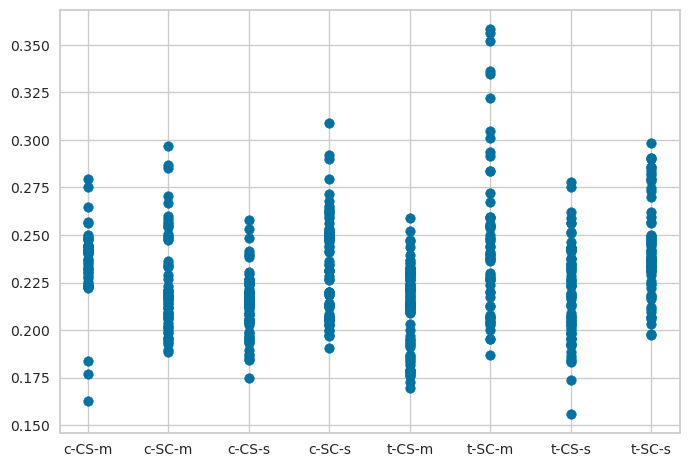

In [20]:
# Visualize DYRK1A_N protein vs class graph
plt.scatter(x_val, y_val)
plt.show()

In [21]:
# Delete high correlated features
# Reduce number of features from 82 to 10
cortex_nuc = cortex_nuc[["MouseID", "AcetylH3K9_N", "RRP1_N", "SHH_N", "GFAP_N", "GluR3_N",
                        "Genotype", "Behavior", "Treatment", "target"]]

In [22]:
# View correlation between remained features
cortex_nuc.drop(columns=["MouseID", "Genotype", "Behavior", "Treatment", "target"])\
            .corr().style.background_gradient(cmap="GnBu")

,AcetylH3K9_N,RRP1_N,SHH_N,GFAP_N,GluR3_N
AcetylH3K9_N,1.000000,0.241938,0.019342,0.317940,-0.138619
RRP1_N,0.241938,1.000000,0.067816,0.420827,0.005160
SHH_N,0.019342,0.067816,1.000000,0.037685,-0.062287
GFAP_N,0.317940,0.420827,0.037685,1.000000,0.098705
GluR3_N,-0.138619,0.005160,-0.062287,0.098705,1.000000


In [23]:
# View on new dataframe
cortex_nuc.head()

,MouseID,AcetylH3K9_N,RRP1_N,SHH_N,GFAP_N,GluR3_N,Genotype,Behavior,Treatment,target
75,3415_1,0.134639,0.158178,0.239752,0.128145,0.292461,Control,C/S,Memantine,c-CS-m
76,3415_2,0.136273,0.161579,0.249031,0.134583,0.291489,Control,C/S,Memantine,c-CS-m
77,3415_3,0.135914,0.167508,0.247956,0.129555,0.270062,Control,C/S,Memantine,c-CS-m
78,3415_4,0.126091,0.144363,0.233225,0.119356,0.276939,Control,C/S,Memantine,c-CS-m
79,3415_5,0.124348,0.153741,0.244469,0.128635,0.283371,Control,C/S,Memantine,c-CS-m


## Define features and target (class) variables

In [24]:
# Define data and target values
numeric_features = list(cortex_nuc.select_dtypes([np.number]).columns)
X_data = cortex_nuc[numeric_features].copy()
y_target = cortex_nuc["target"].copy()

In [25]:
# View on target (class) string values
y_target

75      c-CS-m
76      c-CS-m
77      c-CS-m
78      c-CS-m
79      c-CS-m
         ...  
1045    t-SC-s
1046    t-SC-s
1047    t-SC-s
1048    t-SC-s
1049    t-SC-s
Name: target, Length: 552, dtype: object

In [26]:
# Define labelencoder
le = LabelEncoder()

In [27]:
# Fit labelEncoder for change labels to numerical values in dataset
le.fit(y_target)

LabelEncoder()

In [28]:
# Set new values to 'target' column
y_target = le.transform(y_target)

In [29]:
# View on target (class) numerical values
y_target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [30]:
# Create train & test sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target)

In [31]:
# View shape of X_train
print(f"train_data shape = {X_train.shape}")

train_data shape = (414, 5)


In [32]:
# View shape of X_test
print(f"test_data shape = {X_test.shape}")

test_data shape = (138, 5)


In [33]:
# View shape of y_train
print(f"train_labels shape = {y_train.shape}")

train_labels shape = (414,)


In [34]:
# View shape of y_test
print(f"test_labels shape = {y_test.shape}")

test_labels shape = (138,)


## Rewrite data to recordIO-format for AWS knn model

In [35]:
# Define buffer for rewrite train data
buf = io.BytesIO()

In [36]:
# Rewrite train data to new file
smac.write_numpy_to_dense_tensor(buf, np.array(X_train).astype("float32"),
                                 np.array(y_train).astype("float32"))
buf.seek(0)
boto3.resource('s3').Bucket(bucket).Object(f"{train_path}").upload_fileobj(buf)

In [37]:
# Define buffer for rewrite test data
buf = io.BytesIO()

In [38]:
# Rewrite test data to new file
smac.write_numpy_to_dense_tensor(buf, np.array(X_test).astype("float32"),
                                 np.array(y_test).astype("float32"))
buf.seek(0)
boto3.resource('s3').Bucket(bucket).Object(f"{test_path}").upload_fileobj(buf)

### Determine the number of clusters

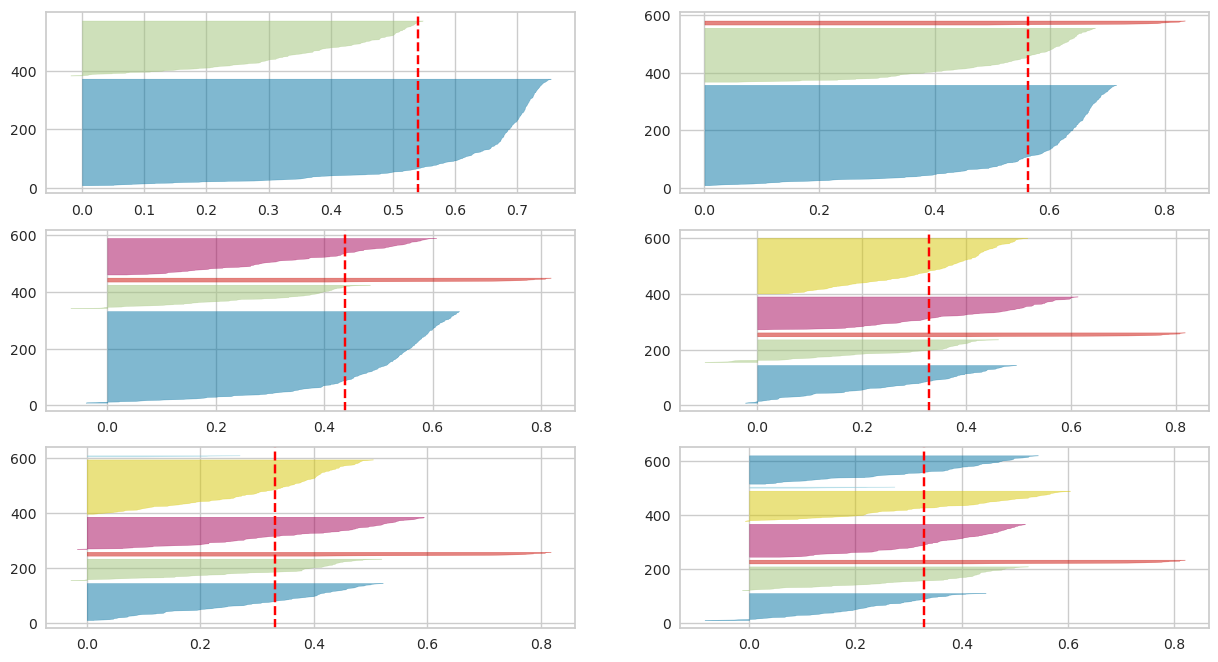

In [59]:
# Visualize Silhouette algorithm for finding best number of clusters
fig, ax = plt.subplots(3, 2, figsize=(15, 8))
for i in [2, 3, 4, 5, 6, 7]:
    # # Create Kmean instances for different number of clusters
    km = KMeans(n_clusters=i, init="k-means++", n_init=10, max_iter=100, random_state=17)
    q, mod = divmod(i, 2)
    # # Create SilhouetteVisualizer instance with KMeans instance.
    # Fit the visualizer
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_data)

In the result we see that Silhouette score high in 3 cluster size.

## Bulding the model for Clusterisation

In [40]:
# Define sagemaker module
sagemaker_session = Session()
aws_role = sagemaker_session.get_caller_identity_arn()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()
model_version = "*"

In [41]:
# Get model for training
container = im_ur_retrieve("knn", boto3.Session().region_name)

In [42]:
# Define session for the model
sess = sagemaker.Session()

In [43]:
# Define role for the model
role = get_execution_role()

In [44]:
# Define model
knn = sagemaker.estimator.Estimator(container,
                                    role,
                                    instance_count=1,
                                    instance_type='ml.m5.2xlarge',
                                    output_path=s3_output_loc,
                                    sagemaker_session=sess)

In [45]:
# Set hyperparameters to the model
knn.set_hyperparameters(feature_dim=5, k=3, sample_size=2000,
                        predictor_type="classifier")

In [46]:
# Set fit input path
fit_input = {"train": s3_train_data, "test": s3_test_data}

In [47]:
# Fit the model
knn.fit(fit_input, job_name=f"job-cortex-{int(time.time())}")
knn_estimator = knn

INFO:sagemaker:Creating training-job with name: job-cortex-1683819199


2023-05-11 15:33:19 Starting - Starting the training job...
2023-05-11 15:33:34 Starting - Preparing the instances for training......
2023-05-11 15:34:42 Downloading - Downloading input data
2023-05-11 15:34:42 Training - Downloading the training image.........
2023-05-11 15:36:03 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/11/2023 15:36:27 INFO 140348397594432] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'_kvstore': 'dist_async', '_log_level': 'info', '_num_gpus': 'auto', '_num_kv_servers': '1', '_tuning_objective_metric': '', '_faiss_index_nprobe': '5', 'epochs': '1', 'feature_dim': 'auto', 'faiss_index_ivf_nlists': 'auto', 'index_metric': 'L2', 'index_type': 'faiss.Flat', 'mini_batch_size': '5000', '_enable_profiler': 'false'}
[05/11/2023 15:36:27 INFO 140348397594432] Merging with provid


2023-05-11 15:36:49 Uploading - Uploading generated training model
2023-05-11 15:36:49 Completed - Training job completed
Training seconds: 147
Billable seconds: 147


## Setting up the endpoint

In [48]:
def predictor_from_estimator(knn_estimator, estimator_name, instance_type, endpoint_name=None):
    knn_predictor = knn_estimator.deploy(
        initial_instance_count=1, instance_type=instance_type, endpoint_name=endpoint_name
    )
    knn_predictor.serializer = CSVSerializer()
    knn_predictor.deserializer = JSONDeserializer()
    return knn_predictor

In [49]:
# Build predictor from estimator
instance_type = "ml.m4.xlarge"
model_name = "knn_%s" % instance_type
endpoint_name = "knn-ml-m4-xlarge-%s" % (str(time.time()).replace('.', '-'))
print("setting up the endpoint..")
predictor = predictor_from_estimator(
    knn_estimator, model_name, instance_type, endpoint_name=endpoint_name
)

INFO:sagemaker:Creating model with name: knn-2023-05-11-15-37-02-354


setting up the endpoint..


INFO:sagemaker:Creating endpoint-config with name knn-ml-m4-xlarge-1683819422-354027
INFO:sagemaker:Creating endpoint with name knn-ml-m4-xlarge-1683819422-354027


-------!

## Inference

In [50]:
# Define batches
batches = np.array_split(X_test.values, 3)
print(f"Data split into 3 batches, of size {batches[0].shape[0]}.")
# Predict y_traget for test
start_time = time.time()
predictions = []
for batch in batches:
    result = predictor.predict(batch, initial_args={"ContentType": "text/csv"})
    cur_predictions = np.array(
                [result["predictions"][i]["predicted_label"] for i in range(len(result["predictions"]))]
                )
    predictions.append(cur_predictions)
predictions = np.concatenate(predictions)
run_time = time.time() - start_time

Data split into 3 batches, of size 46.


In [51]:
# View on pred values
predictions

array([4., 4., 7., 1., 1., 2., 7., 7., 3., 6., 4., 7., 7., 7., 1., 7., 2.,
       1., 1., 6., 6., 1., 1., 6., 4., 1., 0., 0., 4., 7., 3., 1., 7., 4.,
       2., 3., 5., 1., 4., 4., 2., 4., 3., 5., 1., 5., 7., 0., 6., 2., 4.,
       5., 5., 5., 7., 3., 5., 7., 1., 1., 1., 2., 5., 3., 2., 3., 0., 2.,
       3., 3., 7., 4., 1., 7., 7., 4., 4., 3., 2., 7., 1., 4., 2., 7., 5.,
       0., 1., 4., 5., 2., 1., 1., 7., 7., 4., 0., 5., 7., 7., 1., 2., 3.,
       2., 1., 7., 3., 5., 1., 3., 4., 2., 3., 0., 0., 3., 1., 4., 4., 5.,
       4., 5., 5., 1., 2., 3., 0., 4., 4., 5., 7., 7., 3., 1., 3., 2., 4.,
       7., 6.])

In [53]:
# View on time of prediction and accuracy of the model
test_size = y_test.shape[0]
num_correct = sum(predictions == y_test)
accuracy = num_correct / float(test_size)
print("time required for predicting %d data point: %.2f second" % (test_size, run_time))
print("accuracy of model: %.2f%%" % (accuracy * 100))

time required for predicting 138 data point: 0.22 second
accuracy of model: 84.06%


In [57]:
# View on RMSE score
rmse_score = mean_squared_error(y_test, predictions, squared=False)
print("RMSE score is: {:.2f}".format(rmse_score))

RMSE score is: 1.09


In [58]:
def delete_endpoint(predictor):
    """
    Deleting endpoint of predictor;
    param: predictor: predictor model which was deploy on s3 from estimator;
    """
    try:
        boto3.client("sagemaker").delete_endpoint(EndpointName=predictor.endpoint_name)
        print(f"Deleted {predictor.endpoint_name}")
    except:
        print(f"Already deleted: {predictor.endpoint_name}")

In [60]:
# Delete endpoint after using
delete_endpoint(predictor)

Deleted knn-ml-m4-xlarge-1683819422-354027
